In [2]:
import os
import re
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image

import tifffile

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

from sklearn.model_selection import train_test_split

In [3]:
data_dir = '/kaggle/input/segmentation-data/data'

def load_data(data_dir):
    image_files = sorted(glob(os.path.join(data_dir, 'images', '*.tif')))
    mask_files = sorted(glob(os.path.join(data_dir, 'labels', '*.png')))
    filtered_masks = [
    path for path in mask_files
    if re.fullmatch(r'.*/\d+\.png', path)
    ]

    images = [tifffile.imread(f) for f in image_files]
    masks = []
    for f in filtered_masks:
        mask = Image.open(f).convert('L')
        mask = np.array(mask)
        mask = (mask > 0).astype(np.uint8)
        masks.append(mask)


    images = np.array(images)
    masks = np.array(masks)

    return images, masks
  
images, masks = load_data(data_dir)
print(f'Loaded {len(images)} images and {len(masks)} masks.')
print('Images shape = ', images[0].shape)
print('Masks shape = ', masks[1].shape)

Loaded 306 images and 306 masks.
Images shape =  (128, 128, 12)
Masks shape =  (128, 128)


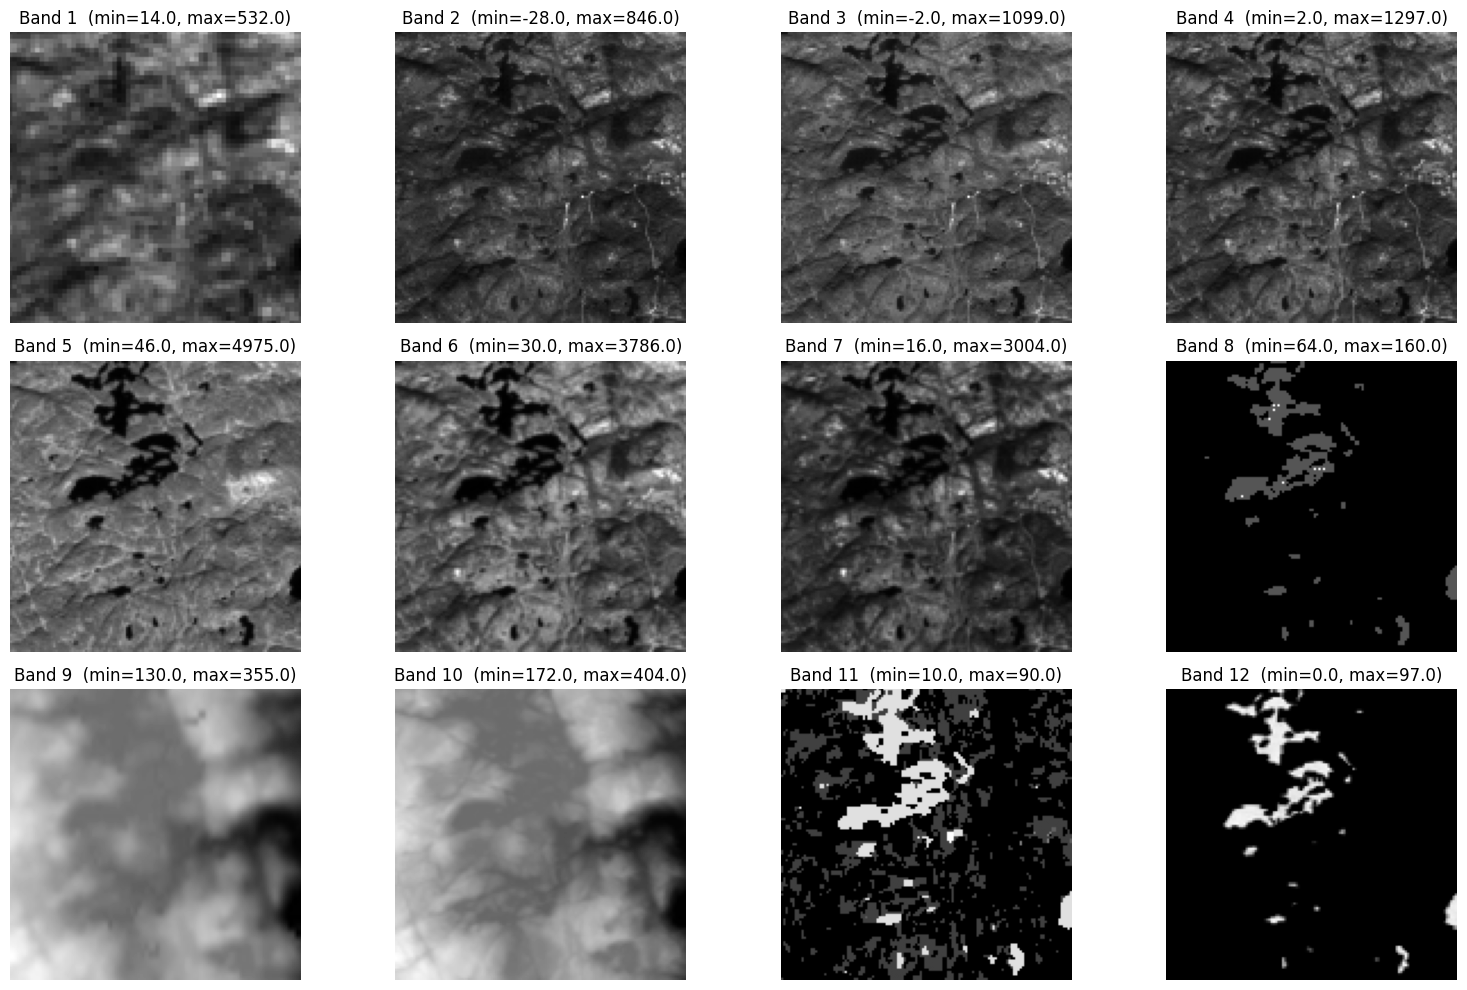

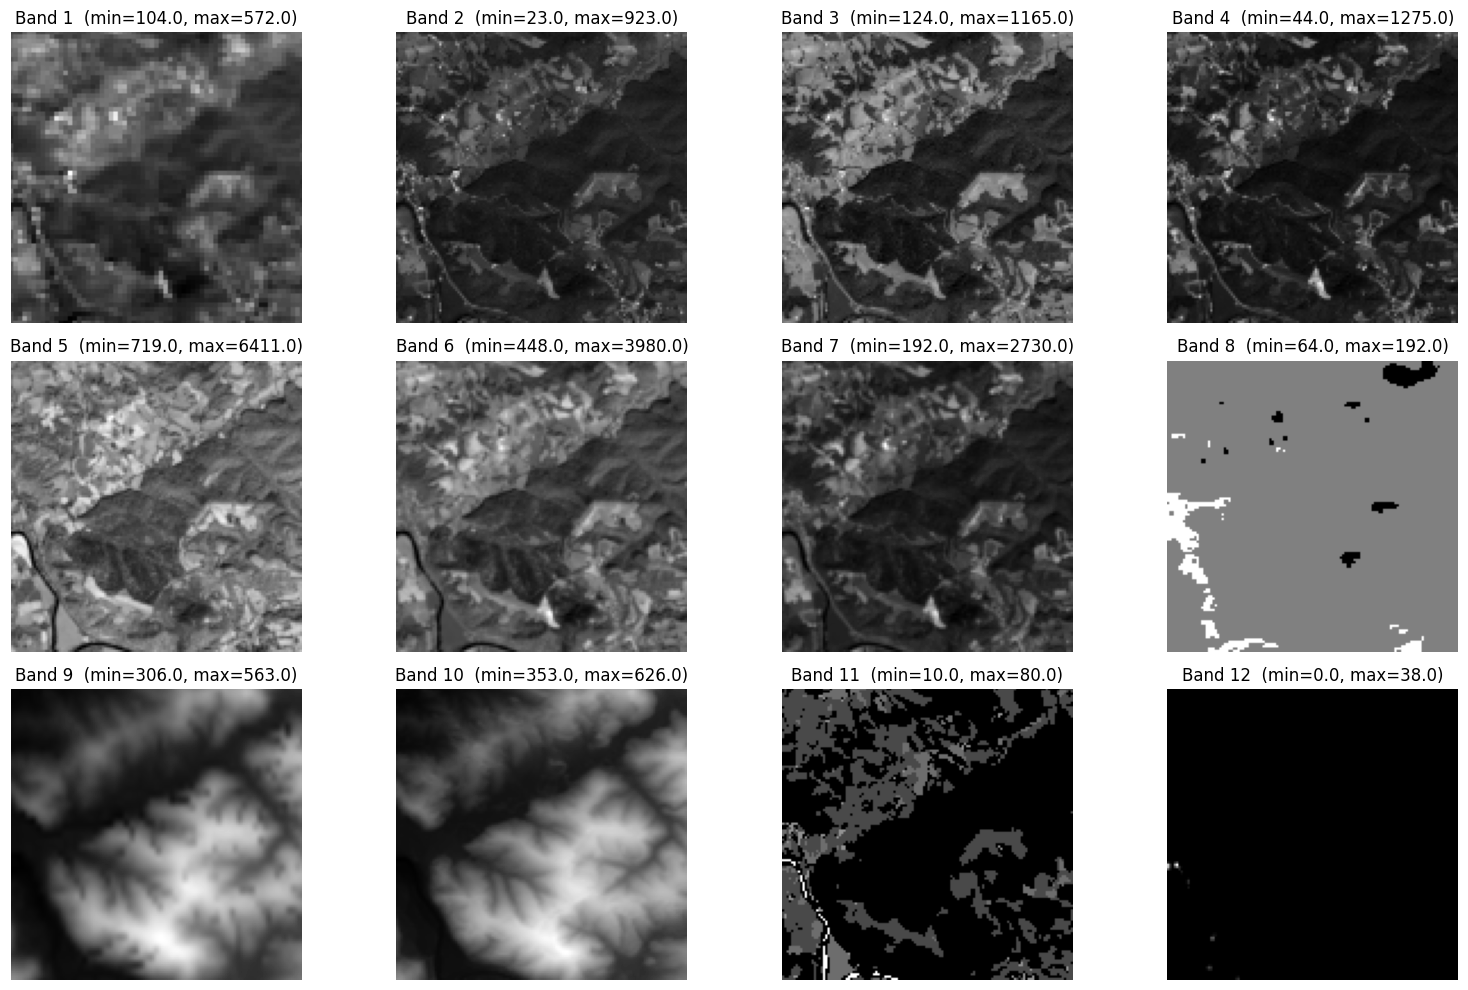

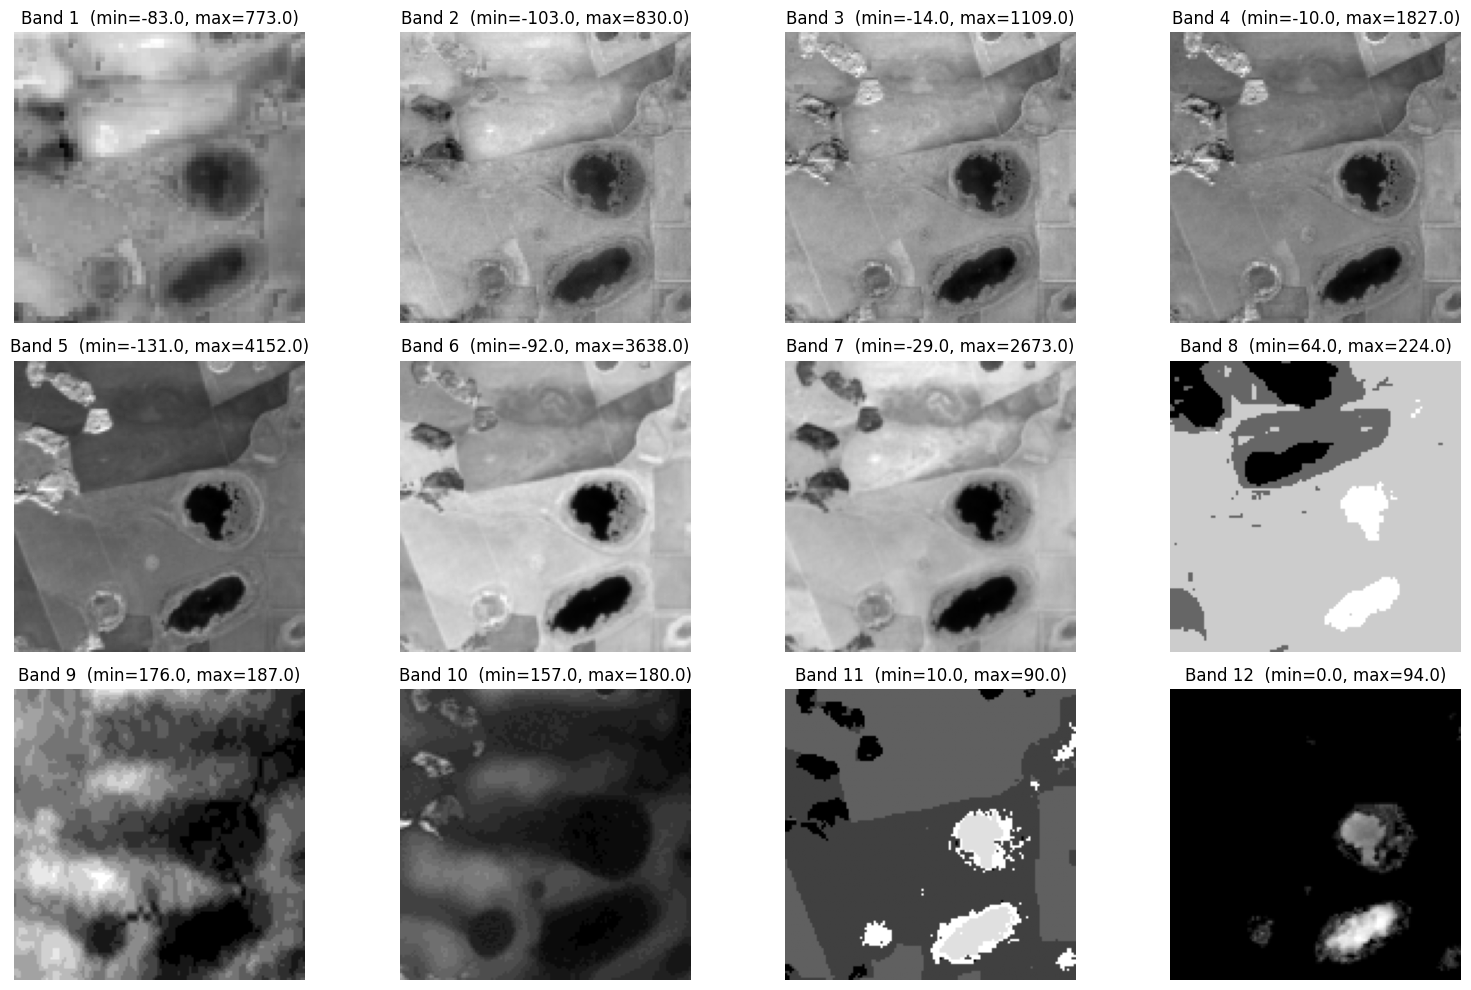

In [4]:
def plot_bands(image):
    norm_img = []
    band_stats = []
    for b in range(12):
        band = image[:, :, b].astype(float)
        band_min = band.min()
        band_max = band.max()
        band_stats.append((band_min, band_max))
        norm_img.append((band - band_min) / (band_max - band_min + 1e-6))
    
    rows, cols = (3, 4)
    fig, axes = plt.subplots(rows, cols, figsize=(16, 10))

    
    for i in range(12):
        row, col = divmod(i, cols)
        ax = axes[row, col]
        ax.imshow(norm_img[i], cmap='gray')
        ax.set_title(f'Band {i+1}  (min={band_stats[i][0]:.1f}, max={band_stats[i][1]:.1f})')
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

    return band_stats

stats=[]
for i in range(3):
    stats.append(plot_bands(images[i]))

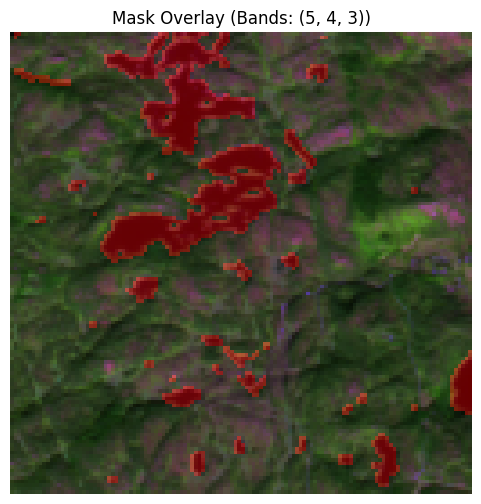

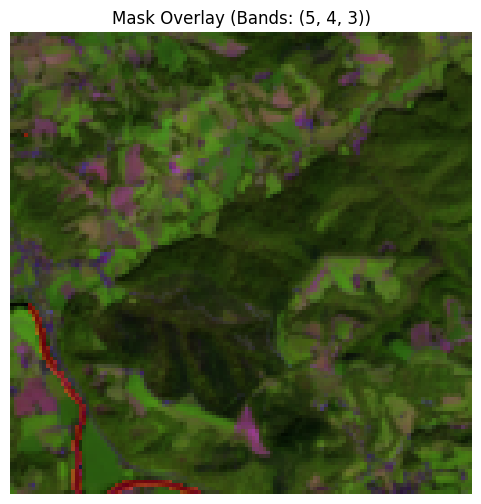

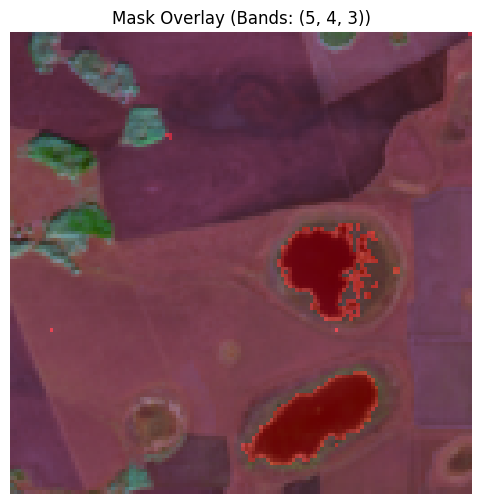

In [5]:
def overlay_mask(image, mask, bands=(3, 2, 1), alpha=0.4):
    rgb = np.stack([image[:, :, b] for b in bands], axis=-1).astype(float)
    for i in range(3):
        bmin, bmax = rgb[..., i].min(), rgb[..., i].max()
        rgb[..., i] = (rgb[..., i] - bmin) / (bmax - bmin + 1e-8)
        
    mask_rgb = np.zeros_like(rgb)
    mask_rgb[..., 0] = mask

    overlay = (1 - alpha) * rgb + alpha * mask_rgb

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.title(f'Mask Overlay (Bands: {bands})')
    plt.axis('off')
    plt.show()

for i in range(3):
    overlay_mask(images[i], masks[i], bands=(5, 4, 3))

In [6]:
def normalize(image, mask):
    image = tf.cast(image, tf.float32)
    max_val = tf.reduce_max(image)
    image = tf.cond(max_val > 0, lambda: image / max_val, lambda: image)
    return image, mask

In [7]:
def augment(image, mask):

    image, mask = normalize(image, mask)

    mask = tf.expand_dims(mask, axis=-1)
        
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
        
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
        
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)

    mask = tf.squeeze(mask, axis=-1) 
    
    return image, mask

In [10]:
split_index = int(0.8 * len(images))  # 80/20 split

train_images, val_images = images[:split_index], images[split_index:]
train_masks, val_masks = masks[:split_index], masks[split_index:]

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_masks))

train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

BATCH_SIZE = 64
train_ds = train_ds.shuffle(100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [11]:
def conv_block(inputs, num_filters):
    x = keras.layers.Conv2D(num_filters, 3, padding='same', activation='relu')(inputs)
    x = keras.layers.Conv2D(num_filters, 3, padding='same', activation='relu')(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = keras.layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [13]:
def build_unet(input_shape):
    inputs = keras.layers.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    
    outputs = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)

    return keras.models.Model(inputs, outputs, name="U-Net")

In [14]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        
        loss_pos = -alpha * tf.pow(1 - y_pred, gamma) * y_true * tf.math.log(y_pred)
        loss_neg = -(1 - alpha) * tf.pow(y_pred, gamma) * (1 - y_true) * tf.math.log(1 - y_pred)
        return tf.reduce_mean(loss_pos + loss_neg)
    
    return loss

In [15]:
input_shape = train_images.shape[1:]
model = build_unet(input_shape)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=binary_focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy', 'precision', 'recall']
)

In [16]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)
]

In [23]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 847ms/step - accuracy: 0.8744 - loss: 0.0312 - precision: 0.9490 - recall: 0.5606 - val_accuracy: 0.8965 - val_loss: 0.0266 - val_precision: 0.9786 - val_recall: 0.5748 - learning_rate: 0.0010
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 789ms/step - accuracy: 0.8888 - loss: 0.0285 - precision: 0.9527 - recall: 0.6146 - val_accuracy: 0.8949 - val_loss: 0.0264 - val_precision: 0.9805 - val_recall: 0.5670 - learning_rate: 0.0010
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 793ms/step - accuracy: 0.8875 - loss: 0.0282 - precision: 0.9544 - recall: 0.6009 - val_accuracy: 0.8938 - val_loss: 0.0263 - val_precision: 0.9811 - val_recall: 0.5618 - learning_rate: 0.0010
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 801ms/step - accuracy: 0.8913 - loss: 0.0286 - precision: 0.9532 - recall: 0.6042 - val_accuracy: 0.8973 - val_loss: 0.0259 - val_precision: 0.9776 - val_recall: 0.5789 - learning_rate: 0.0010
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 409ms/step - accuracy: 0.8975 - l

In [25]:
y_true = []
y_pred = []

for images, masks in val_ds:
    preds = model.predict(images)
    y_true.append(masks.numpy())
    y_pred.append((preds > 0.5).astype(np.uint8))

y_true_flat = np.concatenate(y_true).astype(np.uint8).flatten()
y_pred_flat = np.concatenate(y_pred).astype(np.uint8).flatten()

precision_val = precision_score(y_true_flat, y_pred_flat)
recall_val = recall_score(y_true_flat, y_pred_flat)
f1_val = f1_score(y_true_flat, y_pred_flat)
iou_val = jaccard_score(y_true_flat, y_pred_flat)

# Print results
print("🔍 Evaluation Metrics on Validation Set:")
print(f"📌 Precision: {precision_val:.4f}")
print(f"📌 Recall:    {recall_val:.4f}")
print(f"📌 F1 Score:  {f1_val:.4f}")
print(f"📌 IoU:       {iou_val:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
🔍 Evaluation Metrics on Validation Set:
📌 Precision: 0.9695
📌 Recall:    0.6232
📌 F1 Score:  0.7587
📌 IoU:       0.6112


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


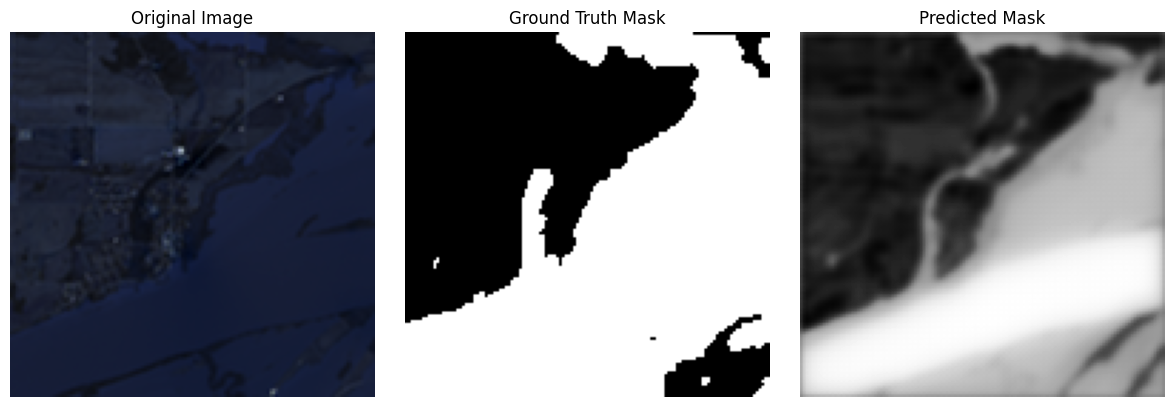

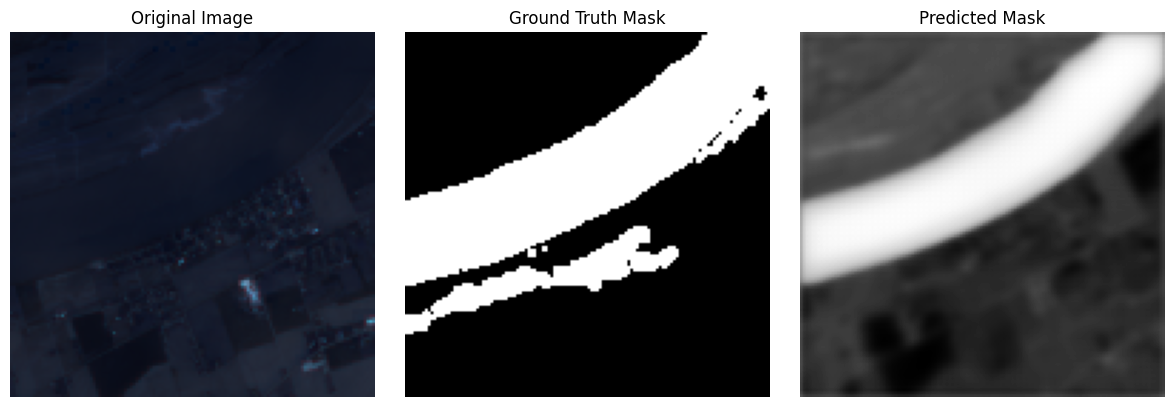

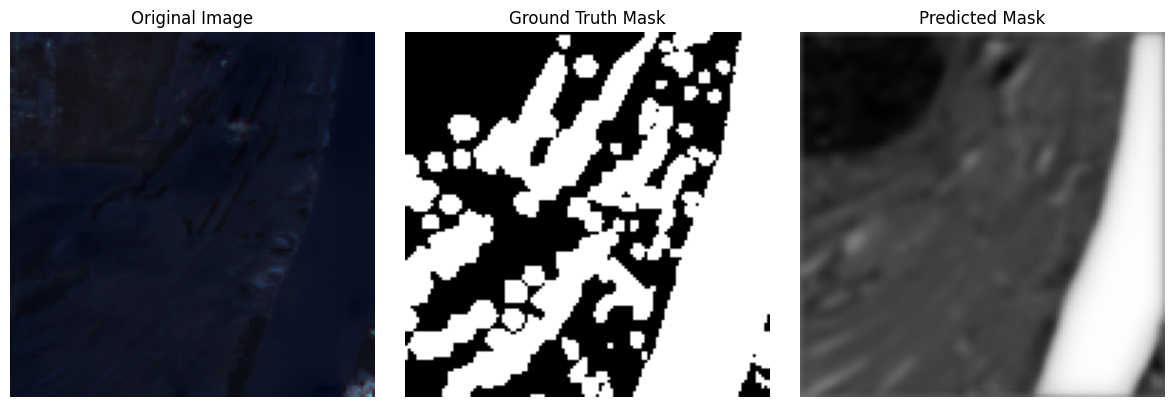

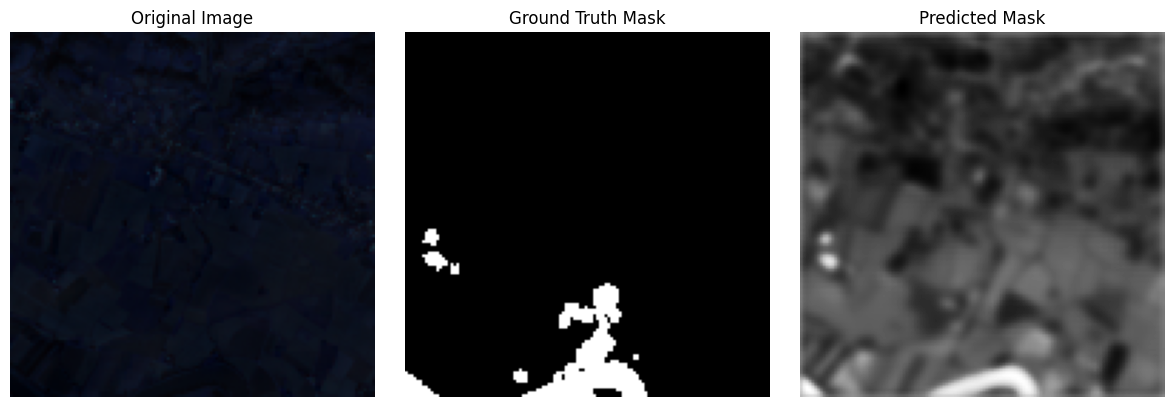

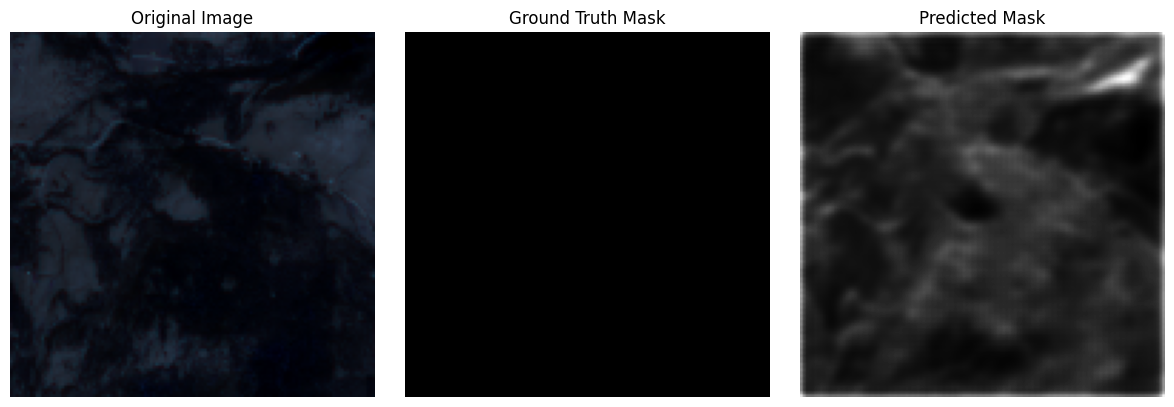

In [26]:
def display_sample_predictions(val_ds, y_true, y_pred, num_samples=5):
    
    y_true_array = np.concatenate(y_true, axis=0)
    y_pred_array = np.concatenate(y_pred, axis=0)

    
    val_ds_unbatched = val_ds.unbatch()

    
    for i, (image, _) in enumerate(val_ds_unbatched.take(num_samples)):
        image_np = image.numpy()
        mask_true = y_true_array[i].squeeze()
        mask_pred = y_pred_array[i].squeeze()

    
        if image_np.shape[-1] == 1:  # Grayscale
            image_np = image_np.squeeze(-1)
        elif image_np.shape[-1] > 3:  
            image_np = image_np[..., :3]  

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(image_np)
        plt.title("Original Image")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask_true, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(mask_pred, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()


y_true = []
y_pred = []

for image_batch, mask_batch in val_ds:
    y_true.append(mask_batch.numpy())
    preds = model.predict(image_batch)
    y_pred.append(preds)


display_sample_predictions(val_ds, y_true, y_pred, num_samples=5)


In [27]:
model.save("myWaterSegmentationModel.h5")